# Training 

This file contains the training part of the RNN.

This cells claims the data on Kaggle thanks to the API. 

In [ ]:
import csv 
import os 
import math 
import numpy as np
from datetime import datetime
dpath = '/Users/mathisp/Code/S9/reservoir/archive/'

#Makes the time a continuous value to work with ESN.
def time_linearisation(date): 
    format_code = "%Y/%m/%d %H:%M:%S"
    dt = datetime.strptime(date, format_code)
    half_hour_index = dt.hour * 2 + (1 if dt.minute >= 30 else 0)
    hh_sin = math.sin(2 * math.pi * half_hour_index / 48)
    hh_cos = math.cos(2 * math.pi * half_hour_index / 48)

    # Week day
    dow = dt.weekday()
    dow_sin = math.sin(2 * math.pi * dow / 7)
    dow_cos = math.cos(2 * math.pi * dow / 7)

    # Month day
    dom = dt.day - 1
    days_in_month = 31  # number of days in a month approximation
    dom_sin = math.sin(2 * math.pi * dom / days_in_month)
    dom_cos = math.cos(2 * math.pi * dom / days_in_month)

    # Months
    month = dt.month - 1
    month_sin = math.sin(2 * math.pi * month / 12)
    month_cos = math.cos(2 * math.pi * month / 12)

    return np.array([
        hh_sin, hh_cos,
        dow_sin, dow_cos,
        dom_sin, dom_cos,
        month_sin, month_cos
    ])
obj=[]
#Notes Function building the data useful for the training. 
def gathering_data(csv_reader,current_size, ind ):
    here = 0   
    if current_size>1500:
        for row in csv_reader:
            if not row or row[0].startswith("R") or here%6!=0:
                continue
            data[here + ind ,0:8]= np.array(time_linearisation(row[1]))
            data[here + ind ,8]= float(row[2])
            data[here + ind ,9] = float(row[3])
            here+=1
    else :
        for row in csv_reader:
            if not row or row[0].startswith("R"):
                continue
            data[here + ind ,0:8]= np.array(time_linearisation(row[1]))
            data[here + ind ,8]= float(row[2])
            data[here + ind ,9] = float(row[3])
            here+=1
    return data

def size(repo):
    lst = os.listdir("./archive/")
    lst.sort()
    list = []
    # sorting to get data in the chronologic time. 
    for file in lst : 
        size = 0 
        with open(dpath + file, mode = 'r') as file :
            csv_reader = csv.reader(file)
            for row in csv_reader:
                if not row or row[0].startswith("R"):
                    continue
                size +=1
            list.append(size)
    return list



def correcting_size(repo): 
    lst = os.listdir("./archive/")
    lst.sort()
    current= 0 
    new_list =[]
     # sorting to get data in the chronologic time. 
    for file in lst : 
        here =0
        size = 0 
        if list[current]<1500:
            new_list.append(list[current])
            current +=1
            continue 
        else : 
            with open(dpath + file, mode = 'r') as file :
                csv_reader = csv.reader(file)
                for row in csv_reader:
                    if not row or row[0].startswith("R") or here%6!=0:
                        here +=1
                        continue
                    else:
                        here+=1
                        size  +=1
                new_list.append(size)
                current+=1
    return new_list
#Doing it with each file 
list = size(dpath)
final_list = correcting_size(dpath)
data = np.zeros((sum(final_list),10))

def gathering_all(repo):
    lst = os.listdir("./archive/")
    lst.sort()
    current = 0
    ind = 0 
    # sorting to get data in the chronologic time. 
    for file in lst : 
        with open(dpath + file, mode = 'r') as file :
            csv_reader = csv.reader(file)
            current_size = list[current]
            gathering_data(csv_reader, current_size, ind)
        ind += final_list[current]
        current +=1
        

gathering_all(dpath)


[]
65712 65712


Building of the ESN

In [14]:
import matplotlib.pyplot as plt 
def plot_train_test(X_train, y_train, X_test, y_test):
    sample = 30000
    test_len = X_test.shape[0]
    fig = plt.figure(figsize=(15, 5))
    plt.plot(np.arange(0, 30000), X_train[:sample,9], label="Training data")
    plt.plot(np.arange(0, 30000), y_train[:sample,9], label="Training ground truth")
    plt.plot(np.arange(30000, 30000+test_len), X_test[:,9], label="Testing data")
    plt.plot(np.arange(30000, 30000+test_len), y_test[:,9], label="Testing ground truth")
    plt.legend()
    plt.show()

65702


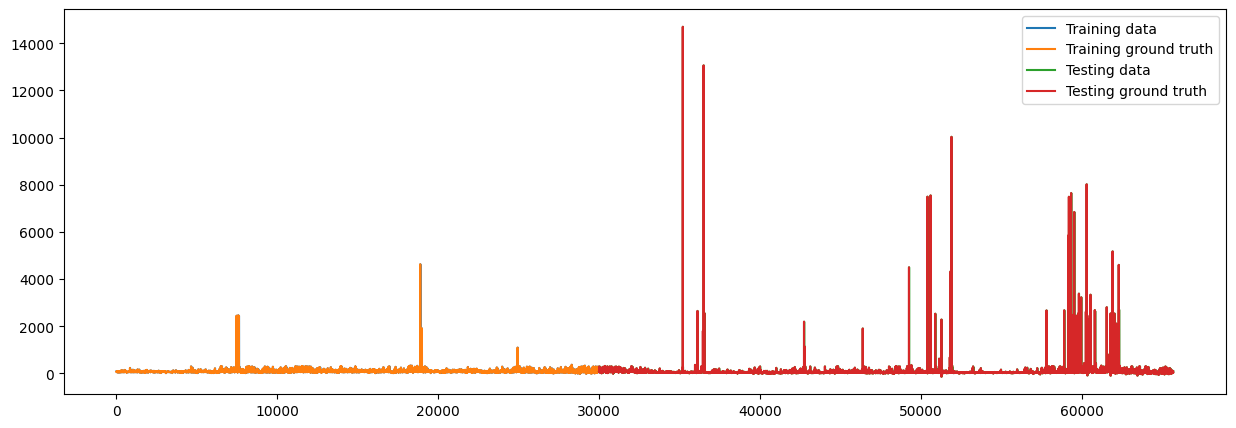

In [209]:
from reservoirpy.datasets import to_forecasting
x,y= to_forecasting(data, forecast=10)
print(len(x))
units = 100 
leak_rate = 0.2
spectral_radius = 0.1
input_scaling = 1.
connectivity = 0.7
input_connectivity = 0.1
regularization = 1e-1
seed = 42
X_train1, y_train1 = x[:30000], y[:30000]
X_test1, y_test1 = x[30000:], y[30000:]
plot_train_test(X_train1, y_train1, X_test1, y_test1)


Functions allowing to build and reset the ESN. 

In [210]:
def reset_esn():
    from reservoirpy.nodes import Reservoir, Ridge

    reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                          lr=leak_rate, rc_connectivity=connectivity,
                          input_connectivity=input_connectivity, seed=seed)
    readout   = Ridge(ridge=regularization, output_dim=10)

    return reservoir >> readout


In [211]:
from reservoirpy.nodes import Reservoir, Ridge

reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)

readout   = Ridge(ridge=regularization, output_dim=10)

esn = reservoir >> readout

In [212]:
esn = esn.fit(X_train1, y_train1)
def plot_results(y_pred, y_test, sample=800):

    fig = plt.figure(figsize=(15, 7))
    plt.subplot(211)
    plt.plot(np.arange(sample), y_pred[:sample,8], lw=3, label="ESN prediction")
    plt.plot(np.arange(sample), y_test[:sample,8], linestyle="--", lw=2, label="True value")
    plt.plot(np.abs(y_test[:sample,8] - y_pred[:sample,8]), label="Absolute deviation")

    plt.legend()
    plt.show()

In [213]:
y_pred1 = esn.run(X_test1)

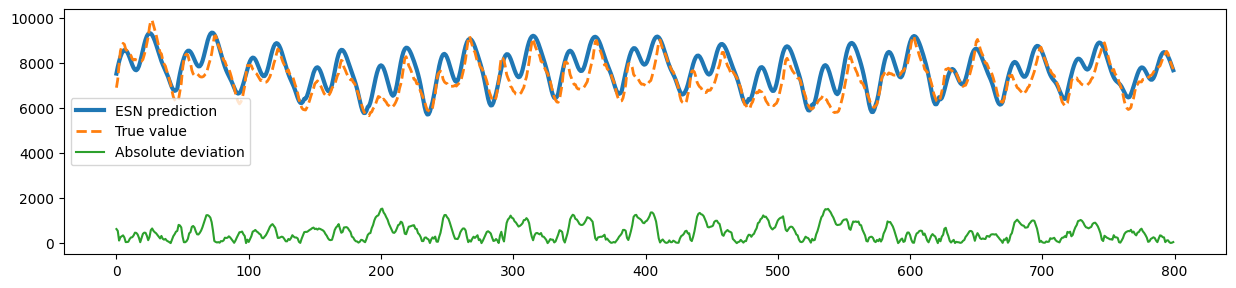

In [214]:
plot_results(y_pred1, y_test1)

# Conclusion 

Without a feedback, the forecast is not precised. This is possibly caused by the extreme values in some cases. 
At the beginning, the system seems to smoothen values then values are exagerates and system struggles to follow peaks. 